sig len: 10000
SNR is 24.730 dB
finished plotting.


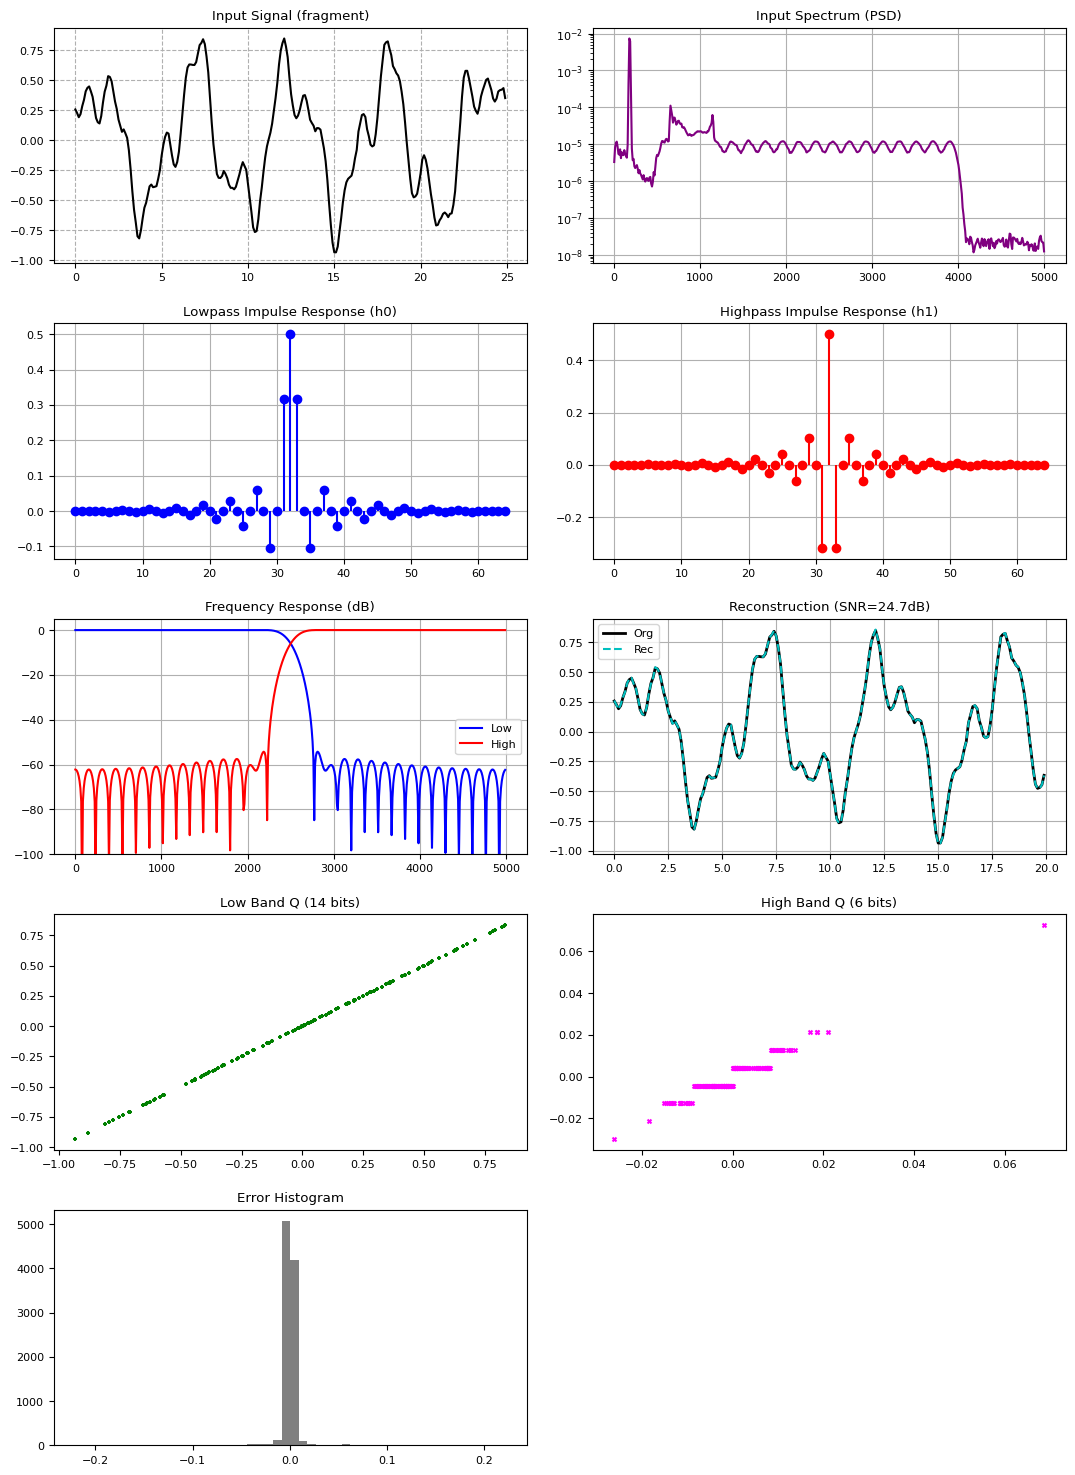

In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, freqz, chirp, welch

# --- junk params ---
fs=10000; T=1.0
t=np.linspace(0,T,int(fs*T))

# creating the messy signal again
# AM + chirp + FM + noise mix
comp1 = 0.5*(1+0.4*np.sin(2*np.pi*3*t))*np.sin(2*np.pi*180*t)
comp2 = 0.25*chirp(t,400,T,4200, method='linear')
comp3 = 0.15*np.sin(2*np.pi*900*t + 250/1.5*np.cos(2*np.pi*1.5*t)) 
noise = np.random.normal(0, 0.02, len(t))
# coloring the noise slightly
noise = lfilter([1], [1,-0.9], noise)

data = comp1 + comp2 + comp3 + noise 
print("sig len:", len(data))

# QMF logic
# using 64 order (65 taps)
TAPS = 65 
h0 = firwin(TAPS, 0.5, window='hamming')
# modulate for highpass
h1 = h0 * ((-1)**np.arange(TAPS)) 

# applying filters
v_low = lfilter(h0, [1], data)
v_high = lfilter(h1, [1], data)

# downsample (decimation)
d_low = v_low[::2]
d_high = v_high[::2]

# === QUANTIZATION ===
# 14 bits low, 6 bits high
b_l = 14; b_h = 6

# ugly manual quantizer
r_l = np.max(np.abs(d_low)); r_h = np.max(np.abs(d_high))

# quant low
L_l = 2**b_l; delt_l = (2*r_l)/L_l
idx_l = np.clip(np.floor((d_low+r_l)/delt_l), 0, L_l-1)
rec_l = (idx_l + 0.5)*delt_l - r_l

# quant high
L_h = 2**b_h; delt_h = (2*r_h)/L_h
idx_h = np.clip(np.floor((d_high+r_h)/delt_h), 0, L_h-1)
rec_h = (idx_h + 0.5)*delt_h - r_h

# === RECONSTRUCTION ===
# upsample
up_l = np.zeros(len(d_low)*2); up_l[::2] = rec_l
up_h = np.zeros(len(d_high)*2); up_h[::2] = rec_h

# synth filters (g0=h0, g1=h1 approx)
y_l = lfilter(h0, [1], up_l)*2
y_h = lfilter(h1, [1], up_h)*2
y_total = y_l + y_h

# delay fix (taps-1)
D = TAPS - 1
y_clean = y_total[D:]
x_clean = data[:len(y_clean)]

# error checks
err = x_clean - y_clean
mse = np.mean(err**2)
snr = 10*np.log10(np.mean(x_clean**2)/mse)
print(f"SNR is {snr:.3f} dB")

# ==========================================
#      PLOTTING SECTION (5x2 GRID)
# ==========================================
plt.rcParams['font.size'] = 8
# made figure taller to fit 10 plots
plt.figure(figsize=(11, 15), facecolor='white') 

# 1. Signal
plt.subplot(5, 2, 1)
plt.plot(t[:250]*1000, data[:250], 'k')
plt.title("Input Signal (fragment)")
plt.grid(True, ls='--')

# 2. PSD
plt.subplot(5, 2, 2)
f, Pxx = welch(data, fs, nperseg=1024)
plt.semilogy(f, Pxx, 'purple')
plt.title("Input Spectrum (PSD)")
plt.grid(True)

# 3. Filter Shape 1 (Lowpass Time) -> NEW
plt.subplot(5, 2, 3)
plt.stem(h0, linefmt='b-', markerfmt='bo', basefmt=' ')
plt.title("Lowpass Impulse Response (h0)")
plt.grid(True)

# 4. Filter Shape 2 (Highpass Time) -> NEW
plt.subplot(5, 2, 4)
plt.stem(h1, linefmt='r-', markerfmt='ro', basefmt=' ')
plt.title("Highpass Impulse Response (h1)")
plt.grid(True)

# 5. Freq Response
plt.subplot(5, 2, 5)
w, H_l = freqz(h0); _, H_h = freqz(h1)
frq = w * fs / (2*np.pi)
plt.plot(frq, 20*np.log10(abs(H_l)+1e-9), 'b', label='Low')
plt.plot(frq, 20*np.log10(abs(H_h)+1e-9), 'r', label='High')
plt.legend(); plt.grid(True)
plt.title("Frequency Response (dB)")
plt.ylim([-100, 5])

# 6. Reconstruction
plt.subplot(5, 2, 6)
plt.plot(t[:200]*1000, x_clean[:200], 'k', lw=2, label='Org')
plt.plot(t[:200]*1000, y_clean[:200], 'c--', lw=1.5, label='Rec')
plt.title(f"Reconstruction (SNR={snr:.1f}dB)")
plt.legend(); plt.grid(True)

# 7. Scatter Low
plt.subplot(5, 2, 7)
plt.scatter(d_low[:150], rec_l[:150], s=8, c='green', marker='+')
plt.title(f"Low Band Q ({b_l} bits)")

# 8. Scatter High
plt.subplot(5, 2, 8)
plt.scatter(d_high[:150], rec_h[:150], s=8, c='magenta', marker='x')
plt.title(f"High Band Q ({b_h} bits)")

# 9. Error Hist
plt.subplot(5, 2, 9)
plt.hist(err, bins=50, color='gray')
plt.title("Error Histogram")



plt.tight_layout(pad=2.0) # added padding so titles don't overlap
print("finished plotting.")
plt.show()